In [154]:
# import default libraries
import pathlib
import zipfile

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# matplotlib darkmode
plt.style.use('dark_background')

# styling
plt.rcParams.update({
    "font.size": 14
})

In [155]:
# read in the level 1 data
cal_df = pd.read_pickle("../data/level1/CDA__CAT_IID_cal_data.pkl")

In [156]:
cal_df

,PSU_VEL,PSU_CHARGE,MP_PEAKS,ACC,QI_CHARGE,QI_TR,QC_CHARGE,QC_TR,QT_CHARGE,QT_TR,TAR,MASS
0,17.40,1.260,3,2000000,8.857710,2.83,43.1122,2.33,4.52835,0.00,CAT,1.664685e-17
1,12.35,0.990,0,2000000,8.392480,8.16,243.3150,0.66,4.80513,0.00,CAT,2.596338e-17
2,18.70,2.030,3,2000000,3.897020,4.00,47.3741,1.83,3.50657,0.00,CAT,2.322057e-17
3,29.10,2.058,6,2000000,102.422000,4.33,496.7530,0.33,23.11490,1.33,CAT,9.721189e-18
4,11.00,2.030,0,2000000,0.781009,1.33,42.1289,1.50,4.81273,0.00,CAT,6.710744e-17
...,...,...,...,...,...,...,...,...,...,...,...,...
4204,9.68,2.429,7,2000000,10.227700,2.84,166.8690,1.83,4.71384,0.00,CAT,1.036900e-16
4205,14.78,0.990,9,2000000,25.061000,2.83,219.0310,1.33,5.48485,0.00,CAT,1.812785e-17
4206,14.89,0.990,4,2000000,7.616550,3.33,42.1660,1.17,4.70756,0.00,CAT,1.786100e-17
4207,12.29,2.506,6,2000000,30.925100,5.34,261.7860,1.00,5.88237,0.00,CAT,6.636472e-17


In [157]:
cal_df["PSU_VEL"].sort_values()

2862     1.51
2069     1.51
2071     1.52
2770     1.52
2875     1.53
        ...  
30      57.10
1481    58.60
1062    58.80
1095    62.70
1602    69.70
Name: PSU_VEL, Length: 4184, dtype: float64

In [158]:
cal_df["QI_CHARGE"].sort_values().tail(51)

2585    9.900000e+16
2587    9.900000e+16
2726    9.900000e+16
2594    9.900000e+16
2802    9.900000e+16
4022    9.900000e+16
2358    9.900000e+16
2736    9.900000e+16
2364    9.900000e+16
2742    9.900000e+16
2741    9.900000e+16
2775    9.900000e+16
3646    9.900000e+16
2913    9.900000e+16
2909    9.900000e+16
2869    9.900000e+16
4087    9.900000e+16
2876    9.900000e+16
2520    9.900000e+16
2523    9.900000e+16
2871    9.900000e+16
2875    9.900000e+16
2870    9.900000e+16
3711    9.900000e+16
2867    9.900000e+16
2868    9.900000e+16
2866    9.900000e+16
2877    9.900000e+16
2861    9.900000e+16
3858    9.900000e+16
2663    9.900000e+16
2845    9.900000e+16
2857    9.900000e+16
2858    9.900000e+16
2727    9.900000e+16
2367    9.900000e+16
2728    9.900000e+16
2729    9.900000e+16
4146    9.900000e+16
2991    9.900000e+16
2995    9.900000e+16
2537    9.900000e+16
2944    9.900000e+16
3602    9.900000e+16
3239    9.900000e+16
3490    9.900000e+16
3045    9.900000e+16
3046    9.900

In [159]:
# defining custom exceptation defination range

class DefinationRangeError(Exception):
    def __init__(self, trise_min=0, trise_max=np.inf, amp_min=0, amp_max=np.inf):

        # set default message
        default_msg = "Out of range. Please set the parameters within the following range: \n\n"

        # set message anf the definition range values.abs
        # super().__init__(default_msg + 'trise (microseconds): ('+ str(trise_min) + ', ' + str(trise_max) + ') \n'
        super().__init__(default_msg \
                        + 'trise (microseconds): (' + str(trise_min) + ', ' + str(trise_max) + ') \n' \
                        + 'amp (femtoCoulomb): (' + str(amp_min) + ', ' + str(amp_max) + ') \n' \
                        + 'log10' + str(np.log10(amp_min)) + ', ' + str(np.log10(amp_max)) + ')')




In [160]:
def srama_velocity_2000(chnl, trise):

    # lower the 'chnl' characters
    chnl = chnl.lower()
    x_10ns = trise * 100.0

    # CAT QC: microseconds  --> km/s
    mean_vel_cat_qc = lambda trise: 1.7 + 19.2 * (trise ** (-0.979)) - 0.0204 * trise

    # IID QT: microseconds -> km/s
    mean_vel_iid_qt = lambda trise: -240 + 361 * (trise ** (-0.117)) + 0.338 * trise

    # IID QI: microseconds -> km/s
    mean_vel_iid_qi = lambda trise: -55.3 + 253 * (trise ** (-0.423)) + 0.222 * trise

    # structure for each channel with error factors
    _vel_cal = {"cat_qc": \
                    {
                        "mean_func": mean_vel_cat_qc, \
                        "err_fac" : 0.50
                    }, \
                "cat_qi": \
                    {
                        "mean_func": mean_vel_cat_qi, \
                        "err_fac": 0.60
                    }, \
                "iit_qt": \
                    {
                        "mean_func": mean_vel_iid_qt, \
                        "error_fac": 0.64
                    }, \
                "iid_qi": \
                    {
                        "mean_func": mean_vel_iid_qi, \
                        "err_fac": 0.60
                    }
                }

    # mean_vel in km/s
    mean_vel = _vel_cal[chnl]["mean_func"](x_10ns)

    # error_vel in km/s
    err_vel = _vel_cal[chnl]["err_fac"] * mean_vel

    return (mean_vel, err_vel)


In [161]:
def srama_velocity_2009(chnl, trise, amp=np.inf, chk=True):

    # lower the channels
    chnl = chnl.lower()


    # CAT QC: microseconds -> km/s
    mean_vel_cat_qc = lambda trise: 1.7 + 19.2 * (trise ** (-0.979)) - 0.0204 * trise

    # IID QT: microseconds -> km/s
    mean_vel_iid_qt = lambda trise: -240 + 361 * (trise ** (-0.117)) + 0.338 * trise

    # IID QI: microseconds -> km/s
    mean_vel_iid_qi = lambda trise: -55.3 + 253 * (trise ** (-0.423)) + 0.222 * trise

    _vel_cal = {'cat_qc': \
                    {
                        'mean_func': mean_vel_cat_qc, \
                        'err_fac':   0.42, \
                        'trise_min': 0.2, \
                        'trise_max': 30.0, \
                        'amp_min':   10.0
                    }, \
                'iid_qt': \
                    {
                        'mean_func': mean_vel_iid_qt, \
                        'err_fac':   0.67, \
                        'trise_min': 2.5, \
                        'trise_max': 80.0, \
                        'amp_min':   65.0
                    }, \
                'iid_qi': \
                    {
                        'mean_func': mean_vel_iid_qi, \
                        'err_fac':   0.62, \
                        'trise_min': 1.0, \
                        'trise_max': 75.0, \
                        'amp_min':   20.0
                    }
                }


    # checking two layers of defination range error if the value is out of range in class and then
    # again inside the dictionary
    if chk:

        if (
            not _vel_cal[chnl]["trise_min"] < trise < _vel_cal[chnl]["trise_max"] or
            not _vel_cal[chnl]["amp_min"] < amp
        ):

            raise DefinationRangeError(trise_min = _vel_cal[chnl]["trise_min"], \
                                        trise_max = _vel_cal[chnl]["trise_max"], \
                                        amp_min = _vel_cal[chnl]["amp_min"])


    mean_vel = _vel_cal[chnl]["mean_func"](trise)
    err_vel = _vel_cal[chnl]["err_fac"] * mean_vel

    return (mean_vel, err_vel)



In [162]:
# In our example we'll only consider IID QI data
iid_qi_cal_df = cal_df.loc[(cal_df["TAR"] == "IID")
                           & (cal_df["QI_CHARGE"] > 0.0)
                           & (cal_df["QI_TR"] > 0.0)].copy()

In [163]:
iid_qi_cal_df["QI_TR"].sort_values()

1602     0.34
1517     0.66
3635     2.33
1529     3.17
1127     3.50
        ...  
1458    81.16
1810    82.50
1311    83.16
852     84.50
1506    89.83
Name: QI_TR, Length: 1634, dtype: float64

50
50


Text(0, 0.5, 'Velocity in km/s')

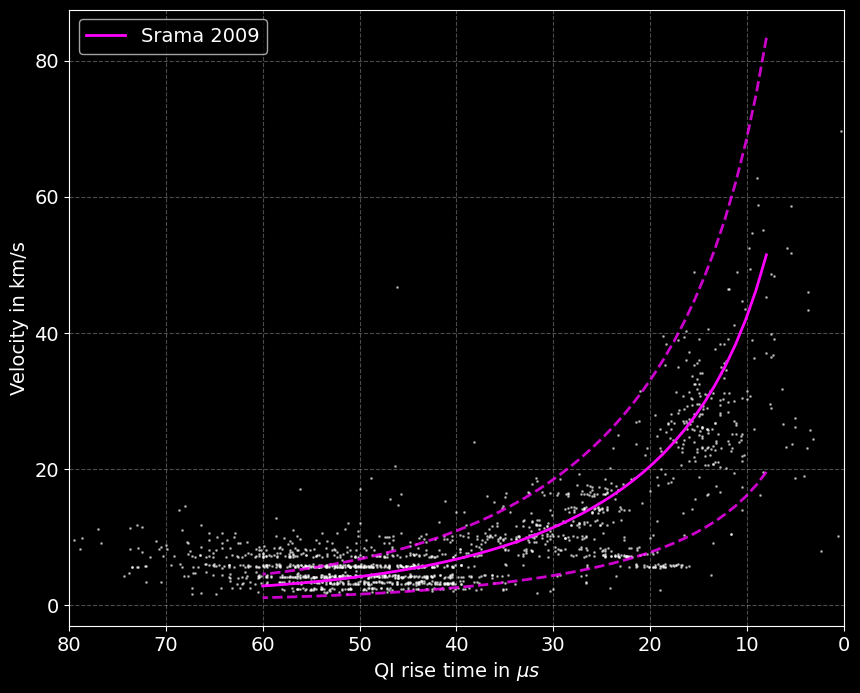

In [164]:
# Compute the velocity values and corresponding errors for both functions
qi_tr_range = np.linspace(8, 60)

print(len(qi_tr_range))

# vel_srama2000 = [srama_velocity_2000(chnl="IID_QI", trise=k)[0] for k in qi_tr_range]
vel_srama2009 = [srama_velocity_2009(chnl="IID_QI", trise=k, chk=False)[0] for k in qi_tr_range]

# vel_srama2000 = np.array(vel_srama2000)
vel_srama2009 = np.array(vel_srama2009)

# vel_err_srama2000 = [srama_velocity_2000(chnl="IID_QI", trise=k)[1] for k in qi_tr_range]
vel_err_srama2009 = [srama_velocity_2009(chnl="IID_QI", trise=k, chk=False)[1] for k in qi_tr_range]

# vel_err_srama2000 = np.array(vel_err_srama2000)
vel_err_srama2009 = np.array(vel_err_srama2009)

print(len(vel_err_srama2009))

# Plot the functions and also the calibration data points
plt.figure(figsize=(10, 8))
plt.scatter(iid_qi_cal_df["QI_TR"], iid_qi_cal_df["PSU_VEL"],
            s=1, alpha=0.5, color="w")

# Plot the Srama 2000 function
# plt.plot(qi_tr_range, vel_srama2000,
#          color="orange", lw=2, label="Srama 2000")
# plt.plot(qi_tr_range, vel_srama2000 + vel_err_srama2000,
#          color="orange", lw=2, linestyle="dashed", alpha=0.8)
# plt.plot(qi_tr_range, vel_srama2000 - vel_err_srama2000,
#          color="orange", lw=2, linestyle="dashed", alpha=0.8)

# Plot the Srama 2009 function
plt.plot(qi_tr_range, vel_srama2009,
         color="magenta", lw=2, label="Srama 2009")
plt.plot(qi_tr_range, vel_srama2009 + vel_err_srama2009,
         color="magenta", lw=2, linestyle="dashed", alpha=0.8)
plt.plot(qi_tr_range, vel_srama2009 - vel_err_srama2009,
         color="magenta", lw=2, linestyle="dashed", alpha=0.8)

plt.legend(fancybox=True, loc="upper left")

plt.grid(linestyle="dashed", alpha=.3)

plt.xlim(80, 0)
plt.xlabel("QI rise time in $\mu s$")
plt.ylabel("Velocity in km/s")

In [165]:
# for iid_qi impacts

def srama_mass_iid_qi_2009(chnl, psu_vel, qi_charge):

    chnl = chnl.lower()
    qi_charge = qi_charge * (10 ** (-15))
    # assuming eq 3.27, QI impacts mass equation -- official calibration equation

    log_m_qi = lambda psu_vel, qi_charge: (
        -2.16 + 1.03 * np.log10(qi_charge) + 0.0180 * (np.log10(qi_charge) ** 2) - \
        3.85 * np.log10(psu_vel) + 3.27 - 0.112 * np.log10(psu_vel) * np.log10(qi_charge) - \
            0.365 * (np.log10(psu_vel) ** 2) \
    )

    m_qi = lambda psu_vel, qi_charge: 10 ** log_m_qi(psu_vel, qi_charge)

    _mass_cal = {'iit_qi': \
                    {
                        'mean_func': log_m_qi, \
                        'mass_func': m_qi, \
                        'err_fac':   0.97 \
                    }
                }

    # log masses and log mass error function
    mean_mass = _mass_cal[chnl]['mean_func'](psu_vel, qi_charge)
    err_mass = _mass_cal[chnl]["err_fac"] * mean_mass

    return (mean_mass, err_mass)




In [166]:
# for iid_qt impacts

def srama_mass_iid_qt_2009(chnl, psu_vel, qt_charge):
    chnl = chnl.lower()
    qt_charge = qt_charge * (10 ** -15)

    # eq. 3.21 impacts of iron dust grains
    if 1.5 <= psu_vel <= 100 and (10 ** -20) <= qt_charge <= (10 ** -10):

        log_m_qt = lambda psu_vel, qt_charge: \
            10.02 + (2.943 * np.log10(qt_charge)) + (0.0941 * (np.log10(qt_charge) ** 2)) - \
            (5.133 * np.log10(psu_vel)) - (0.135 * np.log10(psu_vel) * np.log10(qt_charge)) + \
                (0.0614 * (np.log10(psu_vel) ** 2))

        m_qt = 10 ** log_m_qt
        err_fac = 0.75

    # # standard QT impacts mass equation eq. 3.25
    # # assuming smooth surface mass
    elif psu_vel >= 200:

        log_m_qt = lambda psu_vel, qt_charge : \
            -9.64 + (0.214 * np.log10(qt_charge)) - (3.82 * np.log10(psu_vel)) - \
                (0.0628 * np.log10(psu_vel) * np.log10(qt_charge))

        m_qt = 10 ** log_m_qt
        err_fac = 1.42

    _mass_cal = {'iit_qt': \
        {
            'mean_func': log_m_qt,
            'mass_func': m_qt,
            'err_fac': err_fac
        }
    }

    # log masses and log mass error function
    mean_mass = _mass_cal[chnl]['mean_func'](psu_vel, qt_charge)
    err_mass = err_fac[chnl]['err_fac'] * mean_mass

    return (mean_mass, err_mass)


In [172]:
# for CAT impacts with qi charge

def srama_mass_cat_2009(chnl, psu_vel, qi_charge):
    chnl = chnl.lower()
    qi_charge = qi_charge * (10 ** -15)

    # assuming eq 3.37, QI impacts mass equation -- official calibration equation

    log_m_qi = lambda psu_vel, qi_charge: (
        -4.15 + (0.558 * np.log10(qi_charge)) - (5.59 * np.log10(psu_vel)) - \
        (0.144 * np.log10(psu_vel) * np.log10(qi_charge)) \
    )

    m_qi = lambda psu_vel, qi_charge: 10 ** log_m_qi(psu_vel, qi_charge)

    _mass_cal = {'cat_qi': \
                    {
                        'mean_func': log_m_qi, \
                        'mass_func': m_qi, \
                        'err_fac':   0.83 \
                    }
                }

    # log masses and log mass error function
    mean_mass = _mass_cal[chnl]['mass_func'](psu_vel, qi_charge)
    err_mass = _mass_cal[chnl]["err_fac"] * _mass_cal[chnl]['mean_func'](psu_vel, qi_charge)

    return (mean_mass, err_mass)



In [176]:
# compute the velocity values and corresponding CAT QI data
cat_qi_cal_df = cal_df.loc[(cal_df["TAR"] == "CAT")
                            & (cal_df["PSU_VEL"] > 0.0)
                            &(cal_df["QI_CHARGE"] > 0.0)].copy()

cat_qi_cal_df.columns

# # a plotting parameter
cat_qi_cal_df.loc[:, "QC_BY_QI"] = cat_qi_cal_df.apply((lambda x: x['QC_CHARGE'] / x['QI_CHARGE']), axis=1)

In [183]:
cat_qi_cal_df["QI_CHARGE"].sort_values().head(2000)

309      0.016499
577      0.041335
249      0.050836
316      0.053577
211      0.074530
          ...    
153     47.559700
497     47.559700
535     47.559800
3906    47.977300
157     48.011300
Name: QI_CHARGE, Length: 2000, dtype: float64

In [170]:
cat_qi_cal_df["PSU_VEL"].sort_values()

2862     1.51
2069     1.51
2770     1.52
2071     1.52
2875     1.53
        ...  
212     51.80
682     53.30
658     55.70
712     56.30
30      57.10
Name: PSU_VEL, Length: 2534, dtype: float64

[ 0.          1.01694915  2.03389831  3.05084746  4.06779661  5.08474576
  6.10169492  7.11864407  8.13559322  9.15254237 10.16949153 11.18644068
 12.20338983 13.22033898 14.23728814 15.25423729 16.27118644 17.28813559
 18.30508475 19.3220339  20.33898305 21.3559322  22.37288136 23.38983051
 24.40677966 25.42372881 26.44067797 27.45762712 28.47457627 29.49152542
 30.50847458 31.52542373 32.54237288 33.55932203 34.57627119 35.59322034
 36.61016949 37.62711864 38.6440678  39.66101695 40.6779661  41.69491525
 42.71186441 43.72881356 44.74576271 45.76271186 46.77966102 47.79661017
 48.81355932 49.83050847 50.84745763 51.86440678 52.88135593 53.89830508
 54.91525424 55.93220339 56.94915254 57.96610169 58.98305085 60.        ]
[   1.            1.12421004    1.2638482     1.42083083    1.59731228
    1.79571449    2.01876025    2.26951054    2.55140652    2.86831681
    3.22459055    3.62511705    4.07539297    4.58159767    5.15067808
    5.79044398    6.50967523    7.31824222    8.22724134

/tmp/ipykernel_70996/3129334898.py:10: RuntimeWarning: divide by zero encountered in log10
  -4.15 + (0.558 * np.log10(qi_charge)) - (5.59 * np.log10(psu_vel)) - \
/tmp/ipykernel_70996/3129334898.py:11: RuntimeWarning: divide by zero encountered in log10
  (0.144 * np.log10(psu_vel) * np.log10(qi_charge)) \
/tmp/ipykernel_70996/3129334898.py:10: RuntimeWarning: invalid value encountered in scalar subtract
  -4.15 + (0.558 * np.log10(qi_charge)) - (5.59 * np.log10(psu_vel)) - \


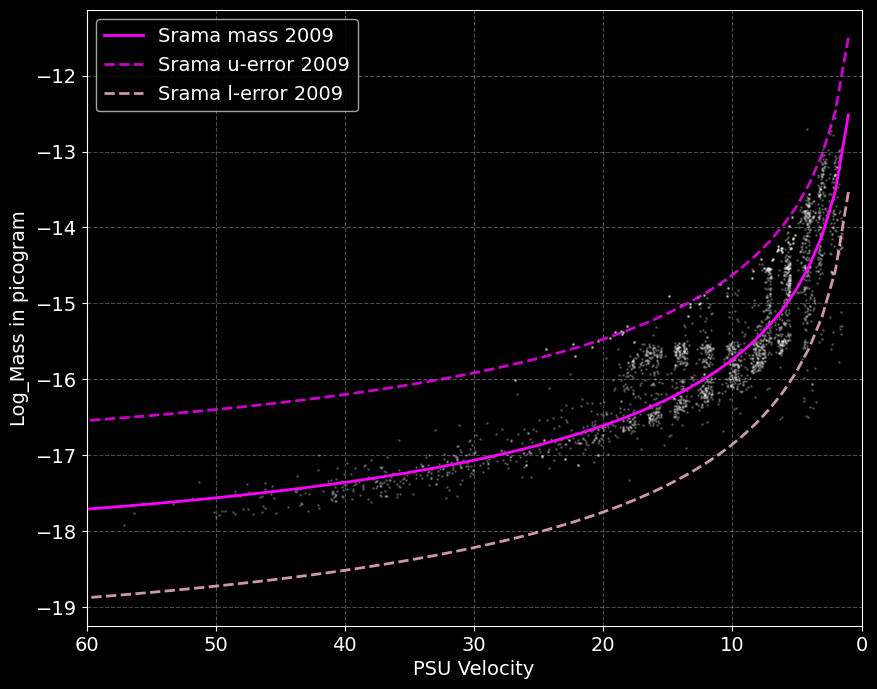

In [203]:
# defining ranges
qi_psu_range = np.linspace(0, 60, 60)
qi_charge_range = np.logspace(0, 3, 60)

print(qi_psu_range)
print(qi_charge_range)

print(len(qi_psu_range))


# vel_srama2009 = [srama_velocity_2009(chnl="IID_QI", trise=k, chk=False)[0] for k in qi_tr_range]

mass_srama_cat_2009 = [srama_mass_cat_2009(chnl="CAT_QI", psu_vel=psu, qi_charge=charge)[0]
                        for psu, charge in zip(qi_psu_range, qi_charge_range)]

mass_srama_cat_2009 = np.array(mass_srama_cat_2009)

print(mass_srama_cat_2009)

mass_err_cat_2009 = [abs(srama_mass_cat_2009(chnl="CAT_QI", psu_vel=psu, qi_charge=charge)[1])
                        for psu, charge in zip(qi_psu_range, qi_charge_range)]

mass_err_srama2009 = np.array(mass_err_cat_2009)

print(f"error mass: {(mass_err_cat_2009)}")

plt.figure(figsize=(10, 8))
plt.scatter(cat_qi_cal_df["PSU_VEL"], (np.log10(cat_qi_cal_df["MASS"])),
            s=1, alpha=0.2, color="w")

# plt for CAT impacts with qi charge
plt.plot(qi_psu_range, np.log10(mass_srama_cat_2009),
        color="magenta", lw=2, label="Srama mass 2009")


plt.plot(qi_psu_range, np.log10(mass_srama_cat_2009) + np.log10(mass_err_cat_2009),
        color="magenta", lw=2, label="Srama u-error 2009", linestyle="dashed", alpha=0.8)


plt.plot(qi_psu_range, np.log10(mass_srama_cat_2009) - np.log10(mass_err_cat_2009),
        color="pink", lw=2, label="Srama l-error 2009", linestyle="dashed", alpha=0.8)

plt.legend(fancybox=True, loc="upper left")

plt.xlim(60,0)
plt.xlabel("PSU Velocity")
plt.ylabel("Log_Mass in picogram")
plt.grid(linestyle="dashed", alpha=.3)